In [1]:
%matplotlib inline
from tensorflow.keras import layers
import matplotlib.pyplot as plt
from tensorflow import keras
import tensorflow as tf
import numpy as np
from sklearn.metrics import f1_score, confusion_matrix, ConfusionMatrixDisplay
import pandas as pd

print("TF version: ", tf.__version__)
print("Keras version: ", keras.__version__)

TF version:  2.6.0
Keras version:  2.6.0


In [3]:
mnist = keras.datasets.mnist
(X_train, y_train), (X_dev, y_dev) = mnist.load_data()

rescale = keras.layers.Rescaling(1/255.)

X_train = tf.reshape(rescale(X_train), shape=(-1, 28, 28, 1))
X_dev = tf.reshape(rescale(X_dev), shape=(-1, 28, 28, 1))

transformations = keras.Sequential([
    layers.experimental.preprocessing.RandomRotation(0.01),
    layers.experimental.preprocessing.RandomTranslation(0.1, 0.1),
    layers.experimental.preprocessing.RandomZoom((-0.3, 0.4))
])

X_train_t = transformations(X_train)
X_dev_t = transformations(X_dev)

print(X_train.shape, X_dev.shape)

11501568/11490434 [==============================] - 0s 0us/step
(60000, 28, 28, 1) (10000, 28, 28, 1)


In [4]:
def plot_img(img: np.array, label: int):
    print('Number:', label)
    plt.imshow(img.squeeze(), cmap='Greys_r')

Number: 3


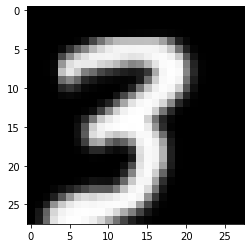

In [8]:
n = np.random.randint(X_train_t.shape[0])
plot_img(X_train_t[n].numpy(), y_train[n])

In [9]:
model = keras.Sequential([
    layers.Conv2D(16, (5, 5), padding='same', activation='relu', input_shape=(28, 28, 1)),
    layers.Conv2D(16, (5, 5), padding='same', activation='relu'),
    layers.MaxPool2D(2, 2),
    layers.Conv2D(32, (3, 3), padding='same', activation='relu'),
    layers.Conv2D(32, (3, 3), padding='same', activation='relu'),
    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.MaxPool2D(2, 2),

    layers.Dropout(rate=0.25),

    layers.Flatten(),

    layers.Dense(units=512, activation='relu'),
    layers.Dropout(rate=0.3),
    layers.Dense(units=32, activation='relu'),
    layers.Dense(units=10, activation='softmax')
])

model.compile(
    optimizer=tf.optimizers.Adam(0.0003),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 16)        416       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 16)        6416      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 14, 14, 32)        4640      
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 14, 14, 32)        9248      
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 12, 12, 32)        9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 6, 6, 32)         

In [10]:
hist = model.fit(X_train_t, y_train,
    batch_size=32, epochs=30,
    validation_data=(X_dev_t, y_dev)
)

Epoch 1/30
1875/1875 [==============================] - 40s 5ms/step - loss: 0.4017 - accuracy: 0.8717 - val_loss: 0.1013 - val_accuracy: 0.9693
Epoch 2/30
1875/1875 [==============================] - 8s 4ms/step - loss: 0.1239 - accuracy: 0.9625 - val_loss: 0.0688 - val_accuracy: 0.9784
Epoch 3/30
1875/1875 [==============================] - 8s 4ms/step - loss: 0.0873 - accuracy: 0.9729 - val_loss: 0.0566 - val_accuracy: 0.9802
Epoch 4/30
1875/1875 [==============================] - 8s 4ms/step - loss: 0.0704 - accuracy: 0.9780 - val_loss: 0.0420 - val_accuracy: 0.9861
Epoch 5/30
1875/1875 [==============================] - 8s 4ms/step - loss: 0.0580 - accuracy: 0.9820 - val_loss: 0.0395 - val_accuracy: 0.9870
Epoch 6/30
1875/1875 [==============================] - 8s 4ms/step - loss: 0.0483 - accuracy: 0.9850 - val_loss: 0.0387 - val_accuracy: 0.9864
Epoch 7/30
1875/1875 [==============================] - 8s 4ms/step - loss: 0.0425 - accuracy: 0.9862 - val_loss: 0.0384 - val_accuracy

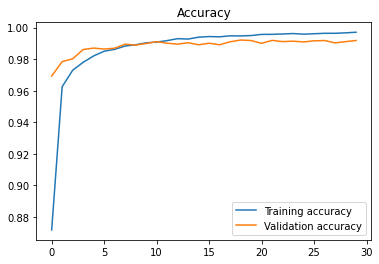

In [18]:
plt.title('Accuracy')
plt.plot(hist.epoch, hist.history['accuracy'])
plt.plot(hist.epoch, hist.history['val_accuracy'])
plt.legend(['Training accuracy', 'Validation accuracy'])
plt.show();

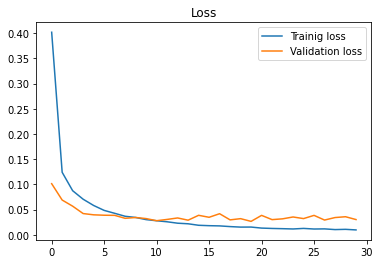

In [19]:
plt.title('Loss')
plt.plot(hist.epoch, hist.history['loss'])
plt.plot(hist.epoch, hist.history['val_loss'])
plt.legend(['Trainig loss', 'Validation loss'])
plt.show();

In [13]:
p_dev = np.argmax(model.predict(X_dev), axis=1)
p_train = np.argmax(model.predict(X_train), axis=1)

In [14]:
print("DEV F1 SCORE: ", f1_score(y_dev, p_dev, average='weighted'))
print("TRAIN F1 SCORE: ", f1_score(y_train, p_train, average='weighted'))

DEV F1 SCORE:  0.9945007166389916
TRAIN F1 SCORE:  0.9947181613319039


DEV CONFUSION MATRIX:


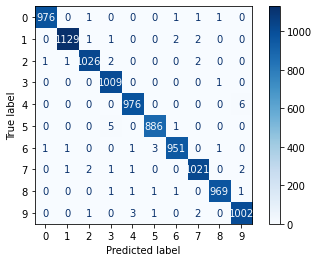

In [15]:
print("DEV CONFUSION MATRIX:")
cm = confusion_matrix(y_dev, p_dev)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.arange(0, 10))
disp.plot(include_values=True, cmap=plt.cm.Blues, xticks_rotation='horizontal', values_format='');

**TODO:**   
1. anomaly detection / outlier removal
2. Retrain the net with better data
3. test the network with external data
4. if succesful save the net and load in the web app, else repeat the steps again

In [16]:
p_train_logits = model.predict(X_train)

In [22]:
def clean_dataset(X, y, y_pred_logits, clean_percent: float = 0.01):
    N_TO_REMOVE = round(X.shape[0] * clean_percent)
    max_accuracies_array = np.array(y_pred_logits.max(axis=1))
    X_ = X.tolist()
    y_ = y.tolist()
    all_concat = list(zip(X_, y_, max_accuracies_array.tolist()))
    all_concat.sort(key=lambda x: x[2])
    X_new, y_new, _ = zip(*all_concat[N_TO_REMOVE:])
    return np.array(X_new), np.array(y_new)

In [23]:
X_train_clean, y_train_clean = clean_dataset(X_train_t.numpy(), y_train, p_train_logits, 0.0005)
X_train_clean.shape, y_train_clean.shape

((59970, 28, 28, 1), (59970,))

Number: 3


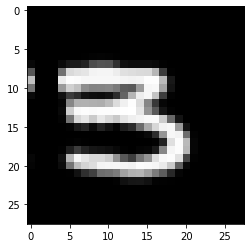

In [24]:
plot_img(X_train_clean[n], y_train_clean[n])

In [29]:
model2 = keras.Sequential([
    layers.Conv2D(16, (5, 5), padding='same', activation='relu', input_shape=(28, 28, 1)),
    layers.Conv2D(16, (5, 5), padding='same', activation='relu'),
    layers.MaxPool2D(2, 2),
    layers.Conv2D(32, (3, 3), padding='same', activation='relu'),
    layers.Conv2D(32, (3, 3), padding='same', activation='relu'),
    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.MaxPool2D(2, 2),

    layers.Dropout(rate=0.25),

    layers.Flatten(),

    layers.Dense(units=512, activation='relu'),
    layers.Dropout(rate=0.3),
    layers.Dense(units=32, activation='relu'),
    layers.Dense(units=10, activation='softmax')
])

model2.compile(
    optimizer=tf.optimizers.Adam(0.0003),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

model2.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_10 (Conv2D)           (None, 28, 28, 16)        416       
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 28, 28, 16)        6416      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 14, 14, 16)        0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 14, 14, 32)        4640      
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 14, 14, 32)        9248      
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 12, 12, 32)        9248      
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 6, 6, 32)         

In [30]:
hist2 = model2.fit(X_train_clean, y_train_clean, batch_size=32, epochs=30, validation_data=(X_dev_t, y_dev))

Epoch 1/30
1875/1875 [==============================] - 10s 5ms/step - loss: 0.4080 - accuracy: 0.8686 - val_loss: 0.1118 - val_accuracy: 0.9641
Epoch 2/30
1875/1875 [==============================] - 9s 5ms/step - loss: 0.1322 - accuracy: 0.9587 - val_loss: 0.0672 - val_accuracy: 0.9780
Epoch 3/30
1875/1875 [==============================] - 9s 5ms/step - loss: 0.0923 - accuracy: 0.9713 - val_loss: 0.0563 - val_accuracy: 0.9814
Epoch 4/30
1875/1875 [==============================] - 9s 5ms/step - loss: 0.0716 - accuracy: 0.9778 - val_loss: 0.0461 - val_accuracy: 0.9847
Epoch 5/30
1875/1875 [==============================] - 9s 5ms/step - loss: 0.0568 - accuracy: 0.9819 - val_loss: 0.0401 - val_accuracy: 0.9870
Epoch 6/30
1875/1875 [==============================] - 9s 5ms/step - loss: 0.0493 - accuracy: 0.9842 - val_loss: 0.0435 - val_accuracy: 0.9860
Epoch 7/30
1875/1875 [==============================] - 8s 5ms/step - loss: 0.0426 - accuracy: 0.9863 - val_loss: 0.0365 - val_accuracy

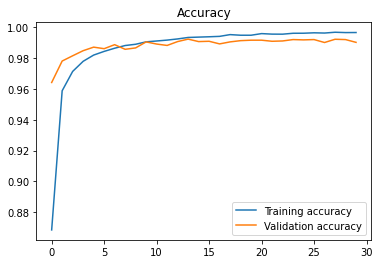

In [31]:
plt.title('Accuracy')
plt.plot(hist2.epoch, hist2.history['accuracy'])
plt.plot(hist2.epoch, hist2.history['val_accuracy'])
plt.legend(['Training accuracy', 'Validation accuracy'])
plt.show();

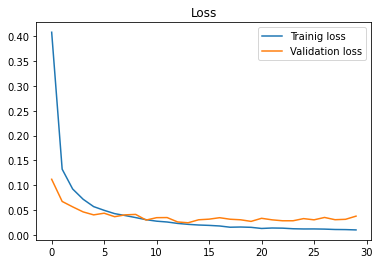

In [32]:
plt.title('Loss')
plt.plot(hist2.epoch, hist2.history['loss'])
plt.plot(hist2.epoch, hist2.history['val_loss'])
plt.legend(['Trainig loss', 'Validation loss'])
plt.show();

## Analysing the models

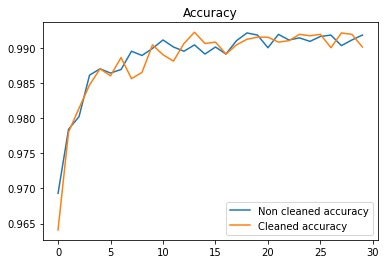

In [33]:
plt.title('Accuracy')
plt.plot(hist.epoch, hist.history['val_accuracy'])
plt.plot(hist2.epoch, hist2.history['val_accuracy'])
plt.legend(['Non cleaned accuracy', 'Cleaned accuracy'])
plt.show();

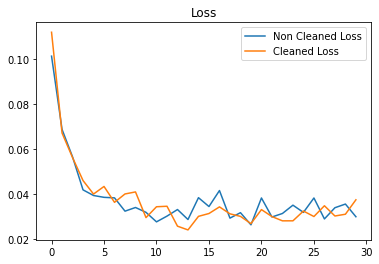

In [34]:
plt.title('Loss')
plt.plot(hist.epoch, hist.history['val_loss'])
plt.plot(hist2.epoch, hist2.history['val_loss'])
plt.legend(['Non Cleaned Loss', 'Cleaned Loss'])
plt.show();

In [35]:
print("Non cleaned F1 Score:", f1_score(y_dev, np.argmax(model.predict(X_dev), axis=1), average='weighted'))
print("Cleaned F1 Score:", f1_score(y_dev, np.argmax(model2.predict(X_dev), axis=1), average='weighted'))

Non cleaned F1 Score: 0.9945007166389916
Cleaned F1 Score: 0.9928957547672528


In [36]:
one = tf.constant([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.16326458752155304, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0.5714263319969177, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.14285658299922943, 1, 1, 0.4897943437099457, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.24489717185497284, 1, 1, 1, 0, 1, 1, 0.14286039769649506, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0.9996798634529114, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.20408114790916443, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.4285736083984375, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0.9983993172645569, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0.5918376445770264, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0.28571316599845886, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.9990395307540894, 0.7543814182281494, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], shape=(1, 28, 28, 1))

Number: 1


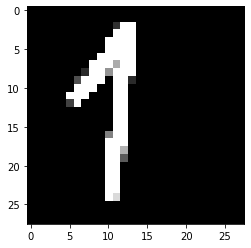

In [37]:
plot_img(one.numpy(), 1)

In [38]:
p = model.predict(one)
print(p.max())
np.argmax(p)

0.9995813


1

In [39]:
p = model2.predict(one)
print(p.max())
np.argmax(p)

0.9999821


1

In [40]:
model.save('DigitRecognitionModel_v4.h5')